## Part 0: Libraries and Set Up


In [ ]:
!pip install pandasql
!pip install geopy
!pip install numpy
!pip install shapely

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=070e7aef6da13f23c4490b2e8a5d3969336b3f4f5816a86c34e42e4fbd5d8f2d
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopy.distance as gp


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

from sklearn.tree import plot_tree

import json
from shapely.geometry import Polygon
from shapely.geometry import Point

## Part 1: Data Preparation

In [ ]:
# OPA Properties
# https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/
!wget "https://opendata-downloads.s3.amazonaws.com/opa_properties_public.csv"

# Historic Assessments
# same link as before: https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/
!wget "https://opendata-downloads.s3.amazonaws.com/assessments.csv"

# Mortality
# https://opendataphilly.org/datasets/philadelphia-vital-statistics-mortality-deaths/
!wget "https://opendata.arcgis.com/api/v3/datasets/f2f78582a66e441aa6fa5b900c63a9cb_0/downloads/data?format=csv&spatialRefId=4326"
# renames to Vital_Natality_PD.csv
!mv "data?format=csv&spatialRefId=4326" "Vital_Mortality_PD.csv"

# Planning District json
# https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Planning_Districts/FeatureServer/0/query?outFields=*&where=1%3D1
!wget "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Planning_Districts/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&returnEnvelope=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token="
# renames to shortened file name to planning_districts.json
!mv "query?where=1=1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=tr" "planning_districts.json"

# Natality
# https://opendataphilly.org/datasets/philadelphia-vital-statistics-natality-births/
!wget "https://opendata.arcgis.com/api/v3/datasets/d37c12521a1f432eb00b5896a19c79b8_0/downloads/data?format=csv&spatialRefId=4326"
# renames to Vital_Natality_PD.csv
!mv "data?format=csv&spatialRefId=4326" "Vital_Natality_PD.csv"

# Gun Violence
# https://controller.phila.gov/philadelphia-audits/mapping-gun-violence/#/?year=All%20Years&layers=Point%20locations
!wget "https://drive.usercontent.google.com/download?id=1hyimWBmQjMB8VoRnapvY87ZV73Lwduas&export=download&authuser=5&confirm=t&uuid=233ffc15-cc2c-4dba-90a5-d376ff5b7d5a&at=APZUnTXeVN0ycm8cwmuicnRJ2Chs:1712929417268"
# renames to Philadelphia_Gun_Violence_Google_Drive.csv
!mv "download?id=1hyimWBmQjMB8VoRnapvY87ZV73Lwduas&export=download&authuser=5&confirm=t&uuid=233ffc15-cc2c-4dba-90a5-d376ff5b7d5a&at=APZUnTXeVN0ycm8cwmuicnRJ2Chs:1712929417268" "Philadelphia_Gun_Violence_Google_Drive.csv"



--2024-04-23 02:51:08--  https://opendata-downloads.s3.amazonaws.com/opa_properties_public.csv
Resolving opendata-downloads.s3.amazonaws.com (opendata-downloads.s3.amazonaws.com)... 3.5.25.52, 52.217.74.60, 16.182.68.81, ...
Connecting to opendata-downloads.s3.amazonaws.com (opendata-downloads.s3.amazonaws.com)|3.5.25.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304801170 (291M) [binary/octet-stream]
Saving to: ‘opa_properties_public.csv’

opa_properties_publ 100%[===================>] 290.68M  30.3MB/s    in 11s     

2024-04-23 02:51:19 (26.4 MB/s) - ‘opa_properties_public.csv’ saved [304801170/304801170]

--2024-04-23 02:51:19--  https://opendata-downloads.s3.amazonaws.com/assessments.csv
Resolving opendata-downloads.s3.amazonaws.com (opendata-downloads.s3.amazonaws.com)... 3.5.27.156, 54.231.232.9, 52.216.33.241, ...
Connecting to opendata-downloads.s3.amazonaws.com (opendata-downloads.s3.amazonaws.com)|3.5.27.156|:443... connected.
HTTP request sent

In [ ]:
pd.set_option('display.max_columns', None)

# PROPERTIES DATA
properties_df = pd.read_csv("opa_properties_public.csv")
# downselecting "useful" columns
properties_targeted_columns = ['central_air', 'frontage', 'total_area', 'total_livable_area', 'garage_spaces','number_of_bedrooms', 'number_of_bathrooms', 'basements','zip_code', 'year_built', 'shape', 'parcel_number', 'market_value']
properties_df= properties_df[properties_targeted_columns]
print(properties_df.info())
# print(properties_df)

#central air need to be changed yes -> 1 and no -> 0
#frontage drop nulls
#number of rooms and garage type deleted because too little non-null values

#CLEAN DATA
#will probably drop central air and basements data because it will make the set < 50000 records
properties_df.drop(columns= ['central_air', 'basements'], inplace = True)
# properties_df['central_air'] = properties_df['central_air'].apply(lambda x: 1 if x == 'Y' else 0 if x == 'N' else x).astype(int)
# properties_df.info()
properties_df = properties_df.dropna()
print(properties_df.info())

#group some years together because of lack of data and also 1700 or 1800 wouldn't make too much difference in price.
properties_df['year_built'] = properties_df['year_built'].apply(lambda x: x//10)
#need 1 hot encoding for year_built, zip_code. Can reduce dimenonality if i just do the decade its built. Or before 1960 or after 1960 as an example.
properties_df = properties_df[properties_df['year_built'] != 0.0]
properties_df['year_built'] = properties_df['year_built'].apply(lambda x: 170 if x < 180 else 180 if x < 190 else x)
unique_counts = properties_df['year_built'].value_counts()
print(unique_counts)

properties_df.head()

# # HISTORIC ASSESSMENTS DATA
# assessments_df = pd.read_csv("assessments.csv")
# # downselecting "useful" columns
# assessments_targeted_columns = ['parcel_number','year','market_value']
# assessments_df= assessments_df[assessments_targeted_columns]
# # assessments_df = assessments_df.dropna()
# # print(assessments_df.info())
# # assessments_df.head()


# # MORTALITY DATA
# mortalities_df = pd.read_csv("Vital_Mortality_PD.csv")
# # downselecting "useful" columns
# mortalities_targeted_columns = ['GEOGRAPHY_NAME','YEAR','SEX','RACE_ETHNICITY','AGE_CATEGORY','LEADING_CAUSE_DEATH','METRIC_NAME','METRIC_VALUE','QUALITY_FLAG']
# mortalities_df= mortalities_df[mortalities_targeted_columns]
# # mortalities_df = mortalities_df.dropna()
# mortalities_df = mortalities_df[
#     (mortalities_df['QUALITY_FLAG'].isnull()) &
#     (mortalities_df['SEX'] == 'All sexes') &
#     (mortalities_df['RACE_ETHNICITY'] == 'All races/ethnicities') &
#     (mortalities_df['AGE_CATEGORY'] == 'All ages') &
#     # (mortalities_df['LEADING_CAUSE_DEATH'] == 'All causes') &
#     (mortalities_df['METRIC_NAME'] == 'age_adjusted_mortality_rate_per_100k')
# ]
# # mortalities_df = mortalities_df.drop('QUALITY_FLAG', axis=1)
# mortalities_df = mortalities_df[['GEOGRAPHY_NAME','YEAR','LEADING_CAUSE_DEATH','METRIC_VALUE']]
# print(mortalities_df.info())


# # NATALITY DATA
# natalities_df = pd.read_csv("Vital_Natality_PD.csv")
# # downselecting "useful" columns
# natalities_targeted_columns = ['GEOGRAPHY_NAME','YEAR','SEX','RACE_ETHNICITY','AGE_CATEGORY','METRIC_NAME','METRIC_VALUE','QUALITY_FLAG']
# natalities_df= natalities_df[natalities_targeted_columns]
# # natalities_df = natalities_df.dropna()
# natalities_df = natalities_df[
#     (natalities_df['QUALITY_FLAG'].isnull()) &
#     (natalities_df['SEX'] == 'All sexes') &
#     (natalities_df['RACE_ETHNICITY'] == 'All races/ethnicities') &
#     (natalities_df['AGE_CATEGORY'] == 'All ages') &
#     (natalities_df['METRIC_NAME'] == 'crude_birth_rate_per_1000')
# ]
# natalities_df= natalities_df[['GEOGRAPHY_NAME','YEAR','METRIC_NAME','METRIC_VALUE']]
# print(natalities_df.info())


# # GUN VIOLENCE DATA
# gun_violence_df = pd.read_csv("Philadelphia_Gun_Violence_Google_Drive.csv")
# gun_violence_df = gun_violence_df.dropna()
# print(gun_violence_df.info())

<ipython-input-4-dd3baebcac28>:4: DtypeWarning: Columns (4,16,25,27,48,76) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_df = pd.read_csv("opa_properties_public.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582961 entries, 0 to 582960
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   central_air          295764 non-null  object 
 1   frontage             578942 non-null  float64
 2   total_area           581220 non-null  float64
 3   total_livable_area   540859 non-null  float64
 4   garage_spaces        497286 non-null  float64
 5   number_of_bedrooms   502519 non-null  float64
 6   number_of_bathrooms  498949 non-null  float64
 7   basements            331657 non-null  object 
 8   zip_code             582851 non-null  float64
 9   year_built           540857 non-null  float64
 10  shape                582961 non-null  object 
 11  parcel_number        582961 non-null  int64  
 12  market_value         582929 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 57.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 493748 entr

,frontage,total_area,total_livable_area,garage_spaces,number_of_bedrooms,number_of_bathrooms,zip_code,year_built,market_value
34,16.0,1600.0,2540.0,0.0,0.0,0.0,19121.0,180.0,412200.0
39,16.0,1244.0,1280.0,2.0,0.0,0.0,19130.0,193.0,580500.0
43,14.0,609.0,840.0,0.0,3.0,1.0,19132.0,191.0,40000.0
74,14.0,776.0,258.0,0.0,0.0,0.0,19125.0,180.0,9300.0
83,17.0,1036.0,2615.0,0.0,6.0,3.0,19132.0,191.0,173500.0


## Part 2: Pre-processing

In [ ]:
#Standardize the scale
features = properties_df.drop(columns = ['market_value'])
target = properties_df['market_value']
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

print(X_train.shape[0])
print(X_test.shape[0])


# object = StandardScaler()
# object.fit_transform(properties_df)

#simple linear regression model

regr = LogisticRegression()
regr.fit(X_train, y_train)
prediction = regr.predict(X_test)
accuracy = regr.score(X_test, y_test)



# # one_hot_mortalities_df = pd.get_dummies(mortalities_df[['QUALITY_FLAG', 'SEX', 'RACE_ETHNICITY', 'AGE_CATEGORY', 'LEADING_CAUSE_DEATH']])
# # one_hot_mortalities_df = pd.concat([one_hot_mortalities_df, mortalities_df[['GEOGRAPHY_NAME','YEAR','METRIC_VALUE']]], axis=1)
# # print(one_hot_mortalities_df)

# pivot_mortalities_df = mortalities_df.pivot_table(index=['GEOGRAPHY_NAME', 'YEAR'],
#                                                   columns='LEADING_CAUSE_DEATH', values='METRIC_VALUE', aggfunc='sum')
# print(pivot_mortalities_df.info())
# pivot_mortalities_df = pivot_mortalities_df.fillna(0)

# pivot_natalities_df = natalities_df.pivot_table(index=['GEOGRAPHY_NAME', 'YEAR'], values='METRIC_VALUE', aggfunc='sum')
# pivot_natalities_df = pivot_natalities_df.rename(columns={'METRIC_VALUE': 'crude_birth_rate_per_1000'})
# print(pivot_natalities_df.info())

# gun_violence_df['year'] = pd.to_datetime(gun_violence_df['date']).dt.year
# # pivot_gun_violence_df = gun_violence_df.pivot_table(index=['zip_code','year'], aggfunc='count')
# gun_violence_df['gun_violence_count'] = gun_violence_df.groupby(['zip_code', 'year'])['date'].transform('count')

# # drop duplicate rows to keep only unique combinations of 'zip_code' and 'year'
# gun_violence_df = gun_violence_df.drop_duplicates(subset=['zip_code', 'year'])
# gun_violence_df = gun_violence_df[['zip_code','year','gun_violence_count']]


# unique_zip_codes = properties_df['zip_code'].unique()
# unique_years = gun_violence_df['year'].unique()
# all_combinations_df = pd.DataFrame([(zip_code, year) for zip_code in unique_zip_codes for year in unique_years], columns=['zip_code', 'year'])
# grouped_gun_violence_df = all_combinations_df.merge(gun_violence_df, on=['zip_code', 'year'], how='left')
# grouped_gun_violence_df['gun_violence_count'].fillna(0, inplace=True)

# # grouped_gun_violence_df = pd.DataFrame()
# # grouped_gun_violence_df['zip_code'] = unique_zip_codes
# # grouped_gun_violence_df['value'] = 0
# # grouped_gun_violence_df = grouped_gun_violence_df.merge(gun_violence_df, on='zip_code', how='left')
# # grouped_gun_violence_df ['value'].fillna(0, inplace=True)


# print(grouped_gun_violence_df.head())



NameError: name 'properties_df' is not defined

In [ ]:
# ORIGINALLY TAKES 1.5 HOURS TO RUN, SWAPPED TO PARALLEL

 # Function maps property to planning district used by many of the data sets

# # Load data from JSON file
# with open('planning_districts.json', 'r') as file:
#     planning_districts = json.load(file)

# def extract_coordinates(point_string):
#     # split the string by spaces and extract the coordinates
#     coordinates_part = point_string.split('(')[1].split(')')[0]
#     # split the coordinates part by space and convert them to floats
#     coordinates = [float(coord) for coord in coordinates_part.split()]
#     # return coordinates
#     return Point(coordinates[0],coordinates[1])


# def find_planning_district(point_coords):
#   for feature in planning_districts['features']:
#       coordinates = feature['geometry']['rings'][0]
#       polygon = Polygon(coordinates)

#       if polygon.contains(point_coords):
#           return feature['attributes']['OBJECTID_1']
#   return None


# # Add planning district to properties_df
# properties_df['point'] = properties_df['shape'].apply(extract_coordinates)
# properties_df['planning_district'] = properties_df['point'].apply(find_planning_district)


In [ ]:
# PARALLEL - FROM 1.5 HOURS TO <12 MINS

import geopandas as gpd
# import pandas as pd
# from shapely.geometry import Point
import multiprocessing

# Load planning districts data
planning_districts = gpd.read_file('planning_districts.json')

# Load properties data
# properties_df = pd.read_csv('your_properties_file.csv')

# Function to find planning district and district name
def find_planning_district(point_string):
    coordinates_part = point_string.split('(')[1].split(')')[0]
    coordinates = [float(coord) for coord in coordinates_part.split()]
    point = Point(coordinates[0], coordinates[1])
    for idx, feature in planning_districts.iterrows():
        polygon = feature['geometry']
        if polygon.contains(point):
            return feature['OBJECTID_1'], feature['DIST_NAME']
    return None, None

# Apply function in parallel
def parallel_apply(df, func, workers=None):
    if workers is None:
        workers = multiprocessing.cpu_count()
    with multiprocessing.Pool(workers) as pool:
        result = pool.map(func, df)
    return result

# Apply function in parallel to properties_df
results = parallel_apply(properties_df['shape'], find_planning_district)
properties_df['planning_district'] = [result[0] for result in results]
properties_df['district_name'] = [result[1] for result in results]

print(properties_df.head())


In [ ]:
assessments_df['next_year'] = assessments_df['year'] + 1

# joins assessment with next year's assessment and downselects to key features

merged_df = pd.merge(assessments_df, assessments_df, left_on=['next_year','parcel_number'], right_on=['year','parcel_number'],how='inner', suffixes=('_current', '_next'))
merged_df = merged_df[['parcel_number','year_current','market_value_current','market_value_next']]

# only want assessments that changes because most don't update every year
merged_df = merged_df[merged_df['market_value_current'] != merged_df['market_value_next']]

def calculate_percentage_change(row):
    current_value = row['market_value_current']
    if pd.notnull(current_value) and current_value != 0:
        return (row['market_value_next'] - current_value) / current_value * 100
    else:
        return float('NaN')

merged_df['percentage_change'] = merged_df.apply(calculate_percentage_change, axis=1)

# classification based on % of current market change to next year market change
percentage_threshold = 5
merged_df['market_value_direction'] = merged_df['percentage_change'].map(lambda x: 0 if 0 <= x < percentage_threshold else (1 if x >= percentage_threshold else -1))

# combining assessments to all other dfs
merged_df = pd.merge(merged_df, properties_df, left_on=['parcel_number'], right_on=['parcel_number'],how='inner')
merged_df = pd.merge(merged_df, pivot_mortalities_df, left_on=['year_current','district_name'], right_on=['YEAR','GEOGRAPHY_NAME'],how='inner', suffixes=('', '_mortalities'))
merged_df = pd.merge(merged_df, pivot_natalities_df, left_on=['year_current','district_name'], right_on=['YEAR','GEOGRAPHY_NAME'],how='inner', suffixes=('', '_natalities'))
merged_df = pd.merge(merged_df, grouped_gun_violence_df, left_on=['year_current','zip_code'], right_on=['year','zip_code'],how='inner', suffixes=('', '_gun_violence'))



corr_matrix = merged_df.corr(numeric_only=True)
sorted_corr_matrix = corr_matrix['market_value_direction'].sort_values(ascending=False)
print(sorted_corr_matrix)
# print(merged_df.head())

In [ ]:
# selected_features = [
#     'planning_district',
#     'market_value',
#     'market_value_direction',
#     'All causes',
#     'Breast cancer',
#     'COVID-19',
#     'Cancer',
#     'Cerebrovascular diseases',
#     'Chronic kidney disease',
#     'Chronic lower respiratory diseases',
#     'Colorectal cancer',
#     'Diabetes',
#     'Drug overdoses',
#     'HIV/AIDS',
#     'Heart disease',
#     'Homicide',
#     'Influenza and pneumonia',
#     'Intentional self-harm (suicide)',
#     'Lung cancer',
#     'Prostate cancer',
#     'Septicemia',
#     'Unintentional injuries (excluding drug overdoses)',
#     'crude_birth_rate_per_1000'
# ]

selected_features = [
    'market_value_direction',
    'Chronic lower respiratory diseases',
    'year_current',
    'Drug overdoses',
    'gun_violence_count',
    'Diabetes',
    'Homicide'
]

merged_df.fillna(0, inplace=True)
data = merged_df[selected_features]
print(data.head())

# Select Attributes
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('market_value_direction', axis=1))
scaled_data = pd.DataFrame(scaled_data, columns=data.drop('market_value_direction', axis=1).columns)
scaled_data['market_value_direction'] = data['market_value_direction']

   market_value_direction  Chronic lower respiratory diseases  year_current  \
0                       1                           43.126573          2016   
1                       1                           43.126573          2016   
2                       1                           43.126573          2016   
3                       1                           43.126573          2016   
4                       1                           43.126573          2016   

   Drug overdoses  gun_violence_count   Diabetes  Homicide  
0       64.005005                 7.0  19.406519       0.0  
1       64.005005                 7.0  19.406519       0.0  
2       64.005005                 7.0  19.406519       0.0  
3       64.005005                 7.0  19.406519       0.0  
4       64.005005                 7.0  19.406519       0.0  


## Part 3: Model-Training

Training Accuracy: [0.5276851735806493, 0.5511096628650207, 0.6416543426494549, 0.6498909637799223, 0.6752364958014789, 0.6938653966662489, 0.7058197769144003, 0.7138889585161048, 0.7219350795839078, 0.7267547311693194]
Test Accuracy: [0.5267140977926078, 0.5513106391170431, 0.6411102733572895, 0.6497970675051334, 0.6744978824435318, 0.6933794276180698, 0.7046770726386037, 0.7129547933778234, 0.7209638090349076, 0.7256641427104723]


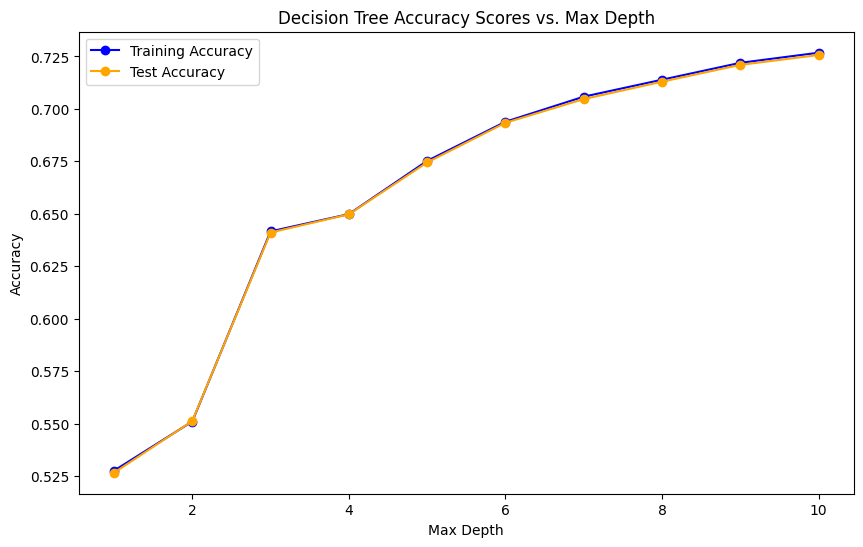

In [ ]:
# X_clf = scaled_data.drop('market_value_direction', axis=1)
# y_clf = scaled_data['market_value_direction']
# X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf,y_clf, test_size=0.2, random_state=0)

# scaler = StandardScaler()
# scaler.fit(X_clf_train)
# X_clf_train_scaled = scaler.transform(X_clf_train)
# X_clf_test_scaled = scaler.transform(X_clf_test)


# # train the model
# clf = LogisticRegression() #fit_intercept default True
# clf.fit(X_clf_train_scaled, y_clf_train)

# y_pred_train_log = clf.predict(X_clf_train_scaled)
# y_pred_test_log = clf.predict(X_clf_test_scaled)

# acc_clf_train = accuracy_score(y_pred_train_log, y_clf_train)
# acc_clf_test = accuracy_score(y_pred_test_log, y_clf_test)

# # depth_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# depth_list = [1,2,3,4,5,6,7,8,9,10]
# all_acc_dt_train = []
# all_acc_dt_test = []

# for i in range(len(depth_list)):
#     dt_clf = DecisionTreeClassifier(max_depth=depth_list[i], random_state=0)
#     dt_clf.fit(X_clf_train_scaled, y_clf_train)
#     y_pred_dt_clf= dt_clf.predict(X_clf_train_scaled)
#     acc_train_dt = accuracy_score(y_clf_train, y_pred_dt_clf)
#     all_acc_dt_train.append(acc_train_dt)

#     y_pred_dt_clf = dt_clf.predict(X_clf_test_scaled)
#     acc_test_dt = accuracy_score(y_clf_test, y_pred_dt_clf)
#     all_acc_dt_test.append(acc_test_dt)

# print("Training Accuracy:", all_acc_dt_train)
# print("Test Accuracy:", all_acc_dt_test)

# plt.figure(figsize = (10, 6))
# plt.plot( depth_list, all_acc_dt_train, color="blue", label="Training Accuracy", marker="o")
# plt.plot( depth_list, all_acc_dt_test, color="orange", label="Test Accuracy", marker="o")
# plt.title("Decision Tree Accuracy Scores vs. Max Depth")
# plt.legend()
# plt.xlabel("Max Depth")
# plt.ylabel("Accuracy")
# plt.show()


#


In [ ]:
# dummy model baseline to compare to
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_clf_train_scaled, y_clf_train)

y_pred_train_base = dummy_clf.predict(X_clf_train_scaled)
acc_train_base = accuracy_score(y_clf_train, y_pred_train_base)
print(acc_train_base)

y_pred_test_base = dummy_clf.predict(X_clf_test)
acc_test_base = accuracy_score(y_clf_test, y_pred_test_base)
print(acc_test_base)


0.4929389647825542
0.4930658046714579


## Part 4: Visualization

In [ ]:
# plt.figure(figsize = (12, 12))
# plot_tree(dt_clf, fontsize=10)
# plt.show()
# #FEATURE IMPORTANCE
# feature_importance = pd.DataFrame({'Features': X_clf.columns.tolist(), 'Importances': dt_clf.feature_importances_})
# feature_importance = feature_importance.sort_values(by='Importances', ascending=False)
# print(feature_importance)


0.7046770726386037


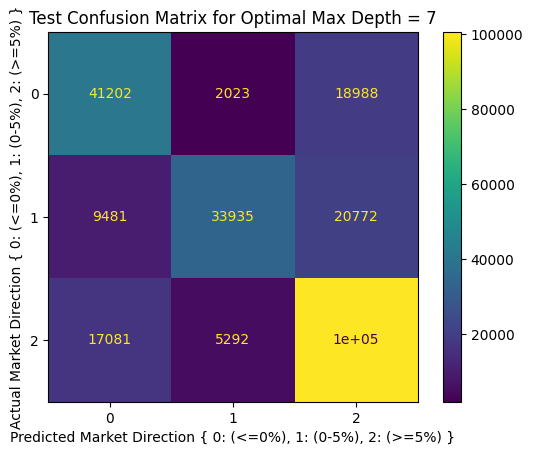

In [ ]:
best_max_depth = 7
surpassed=True

optimal_dt_clf = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
optimal_dt_clf.fit(X_clf_train_scaled, y_clf_train)
y_pred_optimal_dt = optimal_dt_clf.predict(X_clf_test_scaled)

conf_matrix_test = confusion_matrix(y_clf_test, y_pred_optimal_dt)

print(all_acc_dt_test[best_max_depth-1])

disp_test = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_test)
disp_test.plot()

plt.title("Test Confusion Matrix for Optimal Max Depth = 7")
plt.xlabel('Predicted Market Direction { 0: (<=0%), 1: (0-5%), 2: (>=5%) }')
plt.ylabel('Actual Market Direction { 0: (<=0%), 1: (0-5%), 2: (>=5%) }')
plt.show()

